In [70]:
import pandas as pd
import os
import numpy as np
import string
import nltk
import re
import contractions

import gensim
import gensim.downloader
from gensim.models import Word2Vec
from gensim import utils

from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, Softmax, Linear
from torch.optim import SGD, Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


In [6]:
#getting the data
data_file_path = './data'
file_list = os.listdir(data_file_path)

swda_df = pd.concat([pd.read_csv(data_file_path+'/'+f) for f in file_list ], ignore_index=True)

display(swda_df)

print("Shape of the Data : ", swda_df.shape)

,swda_filename,ptb_basename,conversation_no,transcript_index,act_tag,caller,utterance_index,subutterance_index,text,pos,trees,ptb_treenumbers
0,sw07utt/sw_0763_3402.utt,3/sw3402,3402,0,o,A,1,1,All right. /,All/RB right/JJ ./.,NaN,NaN
1,sw07utt/sw_0763_3402.utt,3/sw3402,3402,1,sd^t,A,1,2,I guess tonight's subject is to discuss curre...,I/PRP guess/VBP tonight/RB 's/POS subject/NN i...,NaN,NaN
2,sw07utt/sw_0763_3402.utt,3/sw3402,3402,2,aa,B,2,1,Right. /,Right/UH ./.,NaN,NaN
3,sw07utt/sw_0763_3402.utt,3/sw3402,3402,3,+,A,3,1,"-- satisfied [ with, + with ] the, {F uh } --","--/: satisfied/JJ with/IN ,/, with/IN the/DT ,...",NaN,NaN
4,sw07utt/sw_0763_3402.utt,3/sw3402,3402,4,%,B,4,1,"That's, -/","That/DT 's/BES ,/,",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
223601,sw02utt/sw_0259_2020.utt,2/sw2020,2020,264,%,B,134,6,I - /,[ I/PRP ],(S-UNF (NP-SBJ (PRP I)) (-DFL- N_S)),379
223602,sw02utt/sw_0259_2020.utt,2/sw2020,2020,265,%,B,134,7,"me, - /","[ me/PRP ] ,/,","(NP (PRP me) (, ,) (-DFL- N_S))",380
223603,sw02utt/sw_0259_2020.utt,2/sw2020,2020,266,sv,B,134,8,"{C and } you never would think [ that they, + ...",and/CC [ you/PRP ] never/RB would/MD think/VB...,(S (CC and) (NP-SBJ (PRP you)) (ADVP-TMP (RB n...,381
223604,sw02utt/sw_0259_2020.utt,2/sw2020,2020,267,%,B,134,9,"{C but, } -/","but/CC ,/,","(S-UNF (CC but) (, ,) (-DFL- N_S))",382


Shape of the Data :  (223606, 12)


In [7]:
#Adding binary is_classification column based on act_tag. 

#Experiment on POS, tree and ptb_treenumbers as a feature
parameters = ['utterance_index', 'subutterance_index', 'text', 'act_tag']
swda_df = swda_df[parameters]

# Creating a new column named is_backchannel
# Marking the column as 1 if act_tag is b else 0
is_backchannel = np.where(swda_df.act_tag == 'b', 1, 0)
swda_df['is_backchannel'] = is_backchannel

display(swda_df)


,utterance_index,subutterance_index,text,act_tag,is_backchannel
0,1,1,All right. /,o,0
1,1,2,I guess tonight's subject is to discuss curre...,sd^t,0
2,2,1,Right. /,aa,0
3,3,1,"-- satisfied [ with, + with ] the, {F uh } --",+,0
4,4,1,"That's, -/",%,0
...,...,...,...,...,...
223601,134,6,I - /,%,0
223602,134,7,"me, - /",%,0
223603,134,8,"{C and } you never would think [ that they, + ...",sv,0
223604,134,9,"{C but, } -/",%,0


In [8]:
#Preprocessing the data

#converting all the text to lower
swda_df['text'] = swda_df['text'].str.lower()

#Removing Punctuations
punctuation = string.punctuation
swda_df['text'] = swda_df['text'].apply(lambda x:' '.join(word for word in x.split() if word not in punctuation))

#punkt is a sentence tokenizer which converts the text into sentences and uses unsupervised learning for abbreviations
nltk.download('punkt')

#Remove non-alphabetical character function by using regex
swda_df['text']=swda_df['text'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))
swda_df['text']=swda_df['text'].apply(lambda x: re.sub(' +', ' ', x))

#Performing word contraction using library
swda_df['no_contract'] = swda_df['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
swda_df['text'] = [' '.join(map(str, l)) for l in swda_df['no_contract']]
swda_df = swda_df.drop(['no_contract', 'act_tag'], axis='columns')

display(swda_df)

[nltk_data] Downloading package punkt to /Users/kaus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,utterance_index,subutterance_index,text,is_backchannel
0,1,1,all right,0
1,1,2,i guess tonight s subject is to discuss curren...,0
2,2,1,right,0
3,3,1,satisfied with with the f uh,0
4,4,1,that s,0
...,...,...,...,...
223601,134,6,i,0
223602,134,7,me,0
223603,134,8,c and you never would think that they that the...,0
223604,134,9,c but,0


In [9]:
#Splitting the data in X and y
X = swda_df.iloc[:, 0:3]
y = swda_df.iloc[:, 3:]

print("Features :")
display(X)

print("\n")
print("Backchanneling : ")
display(y)

Features :


,utterance_index,subutterance_index,text
0,1,1,all right
1,1,2,i guess tonight s subject is to discuss curren...
2,2,1,right
3,3,1,satisfied with with the f uh
4,4,1,that s
...,...,...,...
223601,134,6,i
223602,134,7,me
223603,134,8,c and you never would think that they that the...
223604,134,9,c but




Backchanneling : 


,is_backchannel
0,0
1,0
2,0
3,0
4,0
...,...
223601,0
223602,0
223603,0
223604,0


In [24]:
#Train-Validation-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.20, random_state=42)

print("Training Size", X_train.shape)
print("Validation Size", X_val.shape)
print("Testing Size", X_test.shape)

Training Size (143107, 3)
Validation Size (35777, 3)
Testing Size (44722, 3)


In [11]:
#Creating Embedding
word2vec_model = gensim.downloader.load('word2vec-google-news-300')


In [25]:
#Training the Word2Vec data on our data
class embedDataset:
    def __init__(self, dataset):
      self.dataset = dataset

    def __iter__(self):
        for line in self.dataset:
            yield utils.simple_preprocess(line)

In [26]:
embedSentences = embedDataset(swda_df.text)
word2vec_embeddedCorpus = Word2Vec(sentences=embedSentences, vector_size=30, min_count=2, window=3)
localCorpus_model = word2vec_embeddedCorpus.wv

In [27]:
#Converting the shape of the data
def trainedEmbeddings(data, words=10):
    res = list()
    for i, value in enumerate(data['text']):
        temp = list()
        list_split = value.split(' ')
        review = np.zeros(30)
        
        #concatinating the uttrances and sub-uttrances
        review = np.concatenate([review, data['utterance_index'], data['subutterance_index']], axis=0)
        
        if len(list_split)==0:
            res.append(np.zeros(10,300))
            continue
            
        review = np.zeros((1, 300)) 
        for item in list_split[:words]:
            if item in word2vec_model:
                review = np.concatenate([review, np.expand_dims(word2vec_model[item], axis=0)], axis=0)

        review = review[1:]
        if len(review)<words:
            for i in range(words - len(review)):
                review = np.concatenate([review, np.zeros((1,300))], axis=0)

        res.append(review)
    return np.array(res)


In [28]:
X_train, X_val, X_test = trainedEmbeddings(X_train), trainedEmbeddings(X_val), trainedEmbeddings(X_test)


print("Training Size", X_train.shape)
print("Validation Size", X_val.shape)
print("Testing Size", X_test.shape)

Training Size (143107, 10, 300)
Validation Size (35777, 10, 300)
Testing Size (44722, 10, 300)


<AxesSubplot:xlabel='is_backchannel'>

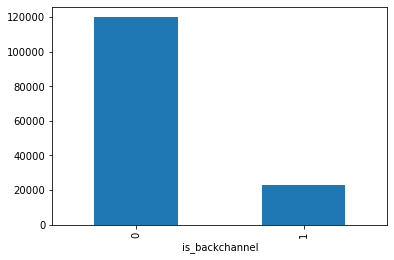

In [16]:
#Showing Class imabalance in Training dataset

y_train.pivot_table(index='is_backchannel', aggfunc='size').plot(kind='bar')


In [36]:
class dataloader(torch.utils.data.Dataset):
    def __init__(self, dataset_word, label_word):
        self.dataset = dataset_word
        self.labels = label_word
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        dataset = self.dataset[idx]
        labels  = self.labels[idx]
        
        return dataset, labels

In [20]:
# training_set = DatasetMapper(X_train, y_train)
# validation_set = DatasetMapper(X_val, y_val)
# test_set = DatasetMapper(X_test, y_test)


In [30]:
class FNN(nn.Module):
    def __init__(self, output_dim, input_dim):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, 50)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(50, 10)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(10, output_dim)

    def forward(self, x):
        return  self.linear3(self.relu2(self.linear2(self.relu1(self.linear1(x)))))

In [57]:
fnn = FNN(1, 300)
print(fnn)

FNN(
  (linear1): Linear(in_features=300, out_features=50, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=50, out_features=10, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=10, out_features=1, bias=True)
)


In [86]:
X_train_word2vec = X_train.astype(np.float32)
X_test_word2vec = X_test.astype(np.float32)

y_train_word2vec = y_train
y_test_word2vec = y_test

train_Dataset = dataloader(X_train_word2vec, y_train_word2vec.values)
training_set = torch.utils.data.DataLoader(train_Dataset, batch_size=50)


test_Dataset = dataloader(X_test_word2vec, y_test_word2vec.values)
testing_set = torch.utils.data.DataLoader(test_Dataset, batch_size=50)


In [66]:
loss = CrossEntropyLoss()
optimizer = Adam(fnn.parameters(), lr=0.9)
softmax = Softmax(dim=1)

In [97]:
#Training the model

epochs = 1
train_it = 0

train_pred = list()
train_actual = list()

for epoch in range(epochs):
    
    print("Current Epoch : {}".format(epoch))
    for j, (x,y) in enumerate(training_set):
        train_actual.append(y)
        
        optimizer.zero_grad()
        
        pred = fnn(x)
        train_pred.append(pred)
        
        pred_loss = loss(pred, y)
        
        pred_loss.backward()
        optimizer.step()
        
#         if train_it % 100 == 0:
#             print("It {}: Prediction Loss: {}".format(train_it, pred_loss))
#         train_it += 1

    
    print("Actual type", type(train_actual))
#     print(train_actual)
    print("Pred type", type(train_pred[0]))
    print(train_pred)
        
    print("F1 Score for epoch : {}".format(epoch), f1_score(train_actual, train_pred))
        
#     print("Current Iter Loss : {}".pred_loss)

Current Epoch : 0
Actual type <class 'list'>
Pred type <class 'torch.Tensor'>


KeyboardInterrupt: 

In [83]:
def train(reviews_dataloader_train, reviews_dataloader_test, model, num_epochs, concat=False, rnn=False, gru=False, prev_loss=float('inf')):

  for epoch in range(num_epochs):
    train_loss = None
    running_loss_train = 0
    val_loss = None
    running_loss_val = 0
    y_pred_label_train = []
    y_gt_train = []

    y_pred_label_val = []
    y_gt_val = []

    print('\n Epoch: {}'.format(epoch))
    for j, (x, y) in enumerate(reviews_dataloader_train):
        y_pred = model(x)
        y_pred_label_train.append(torch.argmax(softmax(y_pred.detach()), axis=1).tolist()[0])
        y_gt_train.append(y)
        optimizer.zero_grad()
        batch_loss = loss(y_pred, y)
        batch_loss.backward()
        running_loss_train += batch_loss.detach().item()
        optimizer.step()

        if j%200==0:
            y_pred_label = torch.argmax(y_pred.detach(), axis=1)
            print('Running train loss :{}'.format(running_loss_train/(j+1)))
            
    print("Pred", y_pred_label_train, type(y_pred_label_train))
    print("Test", y_gt_train ,type(y_gt_train))
    break

    train_loss = running_loss_train/len(reviews_dataloader_train)
    print('Train loss:{}'.format(train_loss))
    print('F-1 Score :{}'.format(f1_score(y_gt_train, y_pred_label_train)))
    print('Accuracy :{}'.format(torch.sum(torch.cat(y_pred_label_train, axis=0)==torch.cat(y_gt_train, axis=0))/len(y_gt_train)))
#     print(y_gt_train, y_pred_label_train)
#     break

    for j, (x, y) in enumerate(reviews_dataloader_test):
        y_pred = model(x)
        y_pred_label_val.append(torch.argmax(softmax(y_pred.detach()), axis=1))
        y_gt_val.append(y)
        batch_loss = loss(y_pred, y)
        running_loss_val += batch_loss.detach().item()
        
        if j%200==0:
            y_pred_label = torch.argmax(y_pred.detach(), axis=1)
            print('Running val loss :{}'.format(running_loss_val/(j+1)))

    val_loss = running_loss_val/len(reviews_dataloader_test)
    print('Val loss:{}'.format(val_loss))
    print('Accuracy :{}'.format(torch.sum(torch.cat(y_pred_label_val, axis=0)==torch.cat(y_gt_val, axis=0))/len(y_gt_val)))
    print('F-1 Score :{}'.format(f1_score(y_gt_val, y_pred_label_val)))
    if val_loss < prev_loss:
        print('Loss improved from {} to {}'.format(prev_loss, val_loss))
        prev_loss = val_loss
        state_dict = {'model_dict':model.state_dict(), 'optimizer_dict':optimizer.state_dict(), 'best_loss':prev_loss,'epoch':epoch}
        if not concat:
            torch.save(state_dict, 'checkpoint.pth')
        else:
            if not rnn:
                torch.save(state_dict, 'checkpoint_concat.pth')
            else:
                if not gru:
                    torch.save(state_dict, 'checkpoint_rnn.pth')
                else:
                    torch.save(state_dict, 'checkpoint_gru.pth')

In [84]:
train(training_set, testing_set, fnn,  1)


 Epoch: 0
Running train loss :1.010372281074524
Running train loss :1.150403815122386
Running train loss :1.1439364212112237
Running train loss :1.1379943843094165
Running train loss :1.1357102973779638
Running train loss :1.1324746402708086
Running train loss :1.1306077558035457
Running train loss :1.1312995188836963
Running train loss :1.12988614094101
Running train loss :1.1316451214870302
Running train loss :1.1304701436525104
Running train loss :1.129875301123207
Running train loss :1.1286971413409
Running train loss :1.127438303691889
Running train loss :1.1274578497691565
Pred [[2], [1], [0], [0], [2], [3], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [2], [0], [0], [2], [0], [2], [0], [0], [0], [0], [1], [0], [2], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [3], [0], [0], [0], [3], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [3], [0], [0], [0], [0], [0], [6], [0

Test [tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0]]), tensor([[0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
    